In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
sns.set()

## Data Prep

### Read Synergy Data

In [7]:
s_df = pd.read_csv('nba_offense.csv')
s_df = s_df[s_df['Season'] != 2016]
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(3135, 74)

Include labels regarding half court offense only

In [8]:
s_df['Overall_Poss'] = s_df['Overall_Poss'] - s_df['Miscellaneous_Poss'] - s_df['Transition_Poss']

In [9]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%']

In [10]:
for col in poss_weights_cols:
    s_df[col] = s_df[col.replace('%', '')] / s_df['Overall_Poss']
    s_df[col] = s_df[col].fillna(0)

Filter in players with 250 shot possessions

In [11]:
s_df = s_df[s_df['Overall_Poss'] >= 250]
s_df.shape

(1421, 74)

### Read BBR Data

In [12]:
bbr_adv_df = pd.read_csv('bbr_nba_advanced_stats.csv')
bbr_adv_df = bbr_adv_df[bbr_adv_df['season'] != 2016]
bbr_adv_df.shape

(3159, 28)

In [13]:
bbr_ros_df = pd.read_csv('bbr_nba_roster_stats.csv')
bbr_ros_df = bbr_ros_df[bbr_ros_df['season'] != 2016]
bbr_ros_df.shape

(2954, 12)

In [14]:
for col in ['player', 'player_alt']:
    bbr_ros_df[col] = bbr_ros_df[col].apply(lambda x: x.replace('(TW)', '').strip())

17-20

In [15]:
bbr_adv_df_17_20 = bbr_adv_df[bbr_adv_df['season'] != 2021].copy()
bbr_ros_df_17_20 = bbr_ros_df[bbr_ros_df['season'] != 2021].copy()
bbr_df_17_20 = bbr_adv_df_17_20.merge(bbr_ros_df_17_20, how='left',
                                      on=['player', 'season', 'team', 'player_alt'])
bbr_adv_df_17_20.shape, bbr_ros_df_17_20.shape, bbr_df_17_20.shape

((2444, 28), (2446, 12), (2444, 36))

20-21

In [16]:
bbr_adv_df_21 = bbr_adv_df[bbr_adv_df['season'] == 2021].copy()
bbr_ros_df_21 = bbr_ros_df[bbr_ros_df['season'] == 2021].copy()
bbr_df_21 = bbr_adv_df_21.merge(bbr_ros_df_21, how='left',
                                on=['player', 'season', 'player_alt'])\
                         .rename(columns={'team_x': 'team'})\
                         .drop('team_y', axis=1)
bbr_adv_df_21.shape, bbr_ros_df_21.shape, bbr_df_21.shape

((715, 28), (508, 12), (715, 36))

In [17]:
bbr_df = pd.concat([bbr_df_17_20, bbr_df_21])\
           .reset_index().drop('index', axis=1)

Filter in players that played over 200 minutes

In [18]:
bbr_df = bbr_df[bbr_df['mp'] >= 200]
bbr_df.shape

(2323, 36)

Convert heights

In [19]:
def convert_height(height):
    feet, inches = height.split('-')
    cm = int(feet) * 12 + int(inches)
    return round(cm * 2.54, 1)

In [20]:
bbr_df[bbr_df['height'].isna()].index

Int64Index([2480, 2500, 2507, 2553, 2576, 2627, 2715, 2718, 2719, 2720, 2762,
            2810, 2835, 2928, 2929, 2952, 3017, 3020, 3024, 3026, 3070],
           dtype='int64')

In [21]:
bbr_df.loc[2480, 'height'] = '6-10'
bbr_df.loc[2480, 'weight'] = 250
bbr_df.loc[2500, 'height'] = '6-7'
bbr_df.loc[2500, 'weight'] = 240
bbr_df.loc[2507, 'height'] = '6-5'
bbr_df.loc[2507, 'weight'] = 210
bbr_df.loc[2553, 'height'] = '6-7'
bbr_df.loc[2553, 'weight'] = 215
bbr_df.loc[2576, 'height'] = '6-4'
bbr_df.loc[2576, 'weight'] = 220
bbr_df.loc[2627, 'height'] = '6-6'
bbr_df.loc[2627, 'weight'] = 205
bbr_df.loc[2715, 'height'] = '6-0'
bbr_df.loc[2715, 'weight'] = 180
bbr_df.loc[2718, 'height'] = '6-5'
bbr_df.loc[2718, 'weight'] = 230
bbr_df.loc[2719, 'height'] = '6-3'
bbr_df.loc[2719, 'weight'] = 210
bbr_df.loc[2720, 'height'] = '6-6'
bbr_df.loc[2720, 'weight'] = 230
bbr_df.loc[2762, 'height'] = '6-8'
bbr_df.loc[2762, 'weight'] = 215
bbr_df.loc[2810, 'height'] = '6-8'
bbr_df.loc[2810, 'weight'] = 215
bbr_df.loc[2835, 'height'] = '6-6'
bbr_df.loc[2835, 'weight'] = 240
bbr_df.loc[2928, 'height'] = '7-0'
bbr_df.loc[2928, 'weight'] = 237
bbr_df.loc[2929, 'height'] = '6-8'
bbr_df.loc[2929, 'weight'] = 216
bbr_df.loc[2952, 'height'] = '6-0'
bbr_df.loc[2952, 'weight'] = 170
bbr_df.loc[3017, 'height'] = '6-9'
bbr_df.loc[3017, 'weight'] = 245
bbr_df.loc[3020, 'height'] = '6-2'
bbr_df.loc[3020, 'weight'] = 205
bbr_df.loc[3024, 'height'] = '6-11'
bbr_df.loc[3024, 'weight'] = 240
bbr_df.loc[3026, 'height'] = '6-3'
bbr_df.loc[3026, 'weight'] = 205
bbr_df.loc[3070, 'height'] = '6-9'
bbr_df.loc[3070, 'weight'] = 245

In [22]:
bbr_df['height_cm'] = bbr_df['height'].apply(convert_height)

Convert weights

In [23]:
bbr_df['weight_kg'] = bbr_df['weight'].apply(lambda x: round(0.453592 * x, 1))

### Merge Synergy Data & BBR Data

In [24]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [25]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [26]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot'}
s_df['Player_Alt'] = s_df['Player_Alt'].apply(lambda x: synergy_name_dict[x] 
                                              if x in synergy_name_dict.keys()
                                              else x)

In [27]:
df = s_df.merge(bbr_df, how='left', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(1420, 114)

In [28]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(1420, 3)

## Functions

In [29]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 
                 'Cut_PPP', 'Hand Off_PPP', 'Offensive Rebounds (put backs)_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP']

In [30]:
def find_optimal_k(x):
    avg_ss_list = []
    k_list = list(range(2, 11))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                eigen_solver="arpack",
                                affinity="nearest_neighbors")
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)
        
    top_ss = np.max(avg_ss_list)
    for i in range(len(k_list)):
        if avg_ss_list[i] == top_ss:
            return k_list[i]

In [31]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method showing the optimal k')

In [32]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 8))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 7, color='red', linestyle='--')
    plt.xlabel('c')
    plt.ylabel('Explained Variance Ratio')

In [33]:
def get_playtype_dist(df, poss_ppp_cols=poss_ppp_cols):
    playtype_dfs = []
    for col in poss_ppp_cols:
        playtype = col.replace('_PPP', '')
        playtype_df = pd.DataFrame()
        playtype_df['PPP'] = df[col]
        playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
        playtype_df['playtype'] = playtype
        playtype_dfs.append(playtype_df)   
    return pd.concat(playtype_dfs)

In [34]:
def show_cluster_res(df, cluster_col, poss_weights_cols=poss_weights_cols):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm'] + poss_weights_cols]\
                    .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

In [57]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [36]:
def check_cluster_robustness(x, k, n_iters):
    cluster_res = []
    for i in range(n_iters):
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        pred = sc.fit(x).labels_
        res = sorted([list(pred).count(cluster) for cluster in list(range(k))])
        cluster_res.append('-'.join([str(n) for n in res]))
    return Counter(cluster_res)

In [37]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'obpm']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('obpm')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

## Clustering

Show correlations among playtype possession%

<AxesSubplot:>

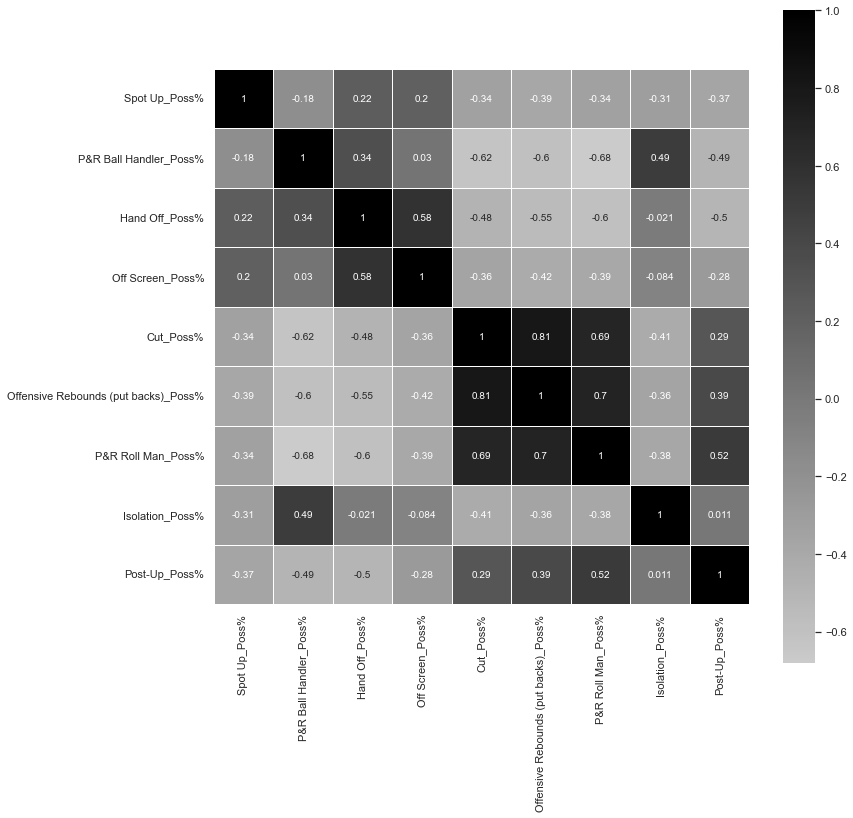

In [38]:
figsize(12, 8)
corr = df[poss_weights_cols].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5)

Show distributions of possession weights and effeiciency of each playtype

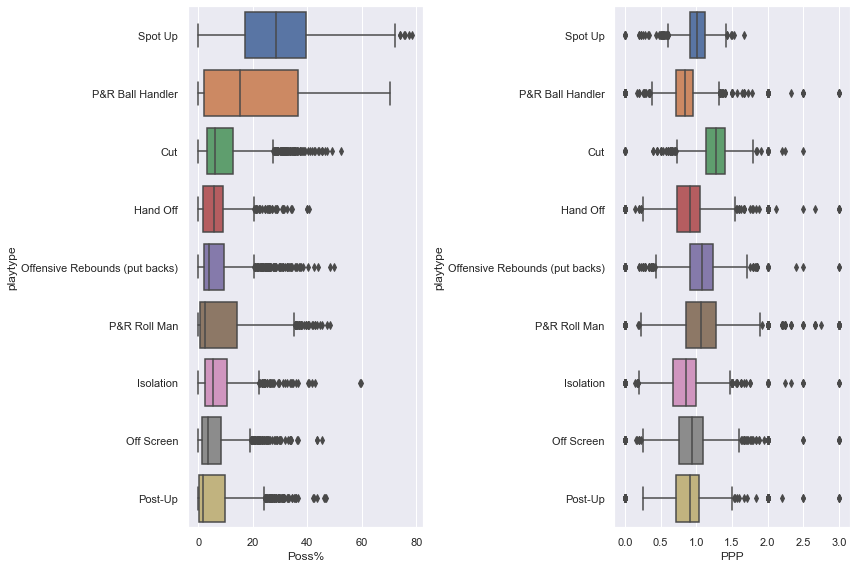

In [39]:
figsize(12, 8)
data = get_playtype_dist(df)
plt.subplot(1, 2, 1)
sns.boxplot(x="Poss%", y="playtype", data=data)
plt.subplot(1, 2, 2)
sns.boxplot(x="PPP", y="playtype", data=data)
plt.tight_layout()

Summary of distribution in playtype weights:
- Outliers exist 
    - Most of them are the result of skewed data
    - A few of them are creditted to players' own unique tendencies (ex. James Harden's iso game)
- There are some common playtypes
    - Spot Up
    - Transition
- Most are skewed
    - Big man
        - Cut
        - Offensive Rebounds
        - P&R Roll Man
        - Post-Up
    - Perimeter players
        - P&R Ball Handler
        - Hand Off
        - Off Screen
    - Star Privilege
        - Post-Up
        - Isolation
    
        

### Clustering

In [40]:
X = df[poss_weights_cols].copy()

Determine how many components reduce down to via PCA

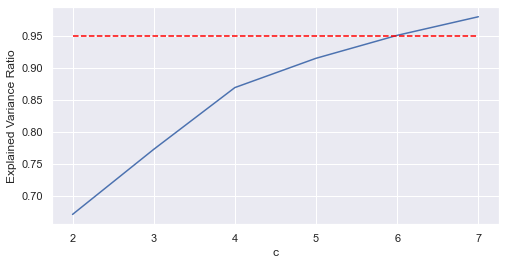

In [41]:
figsize(8, 4)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choose 6

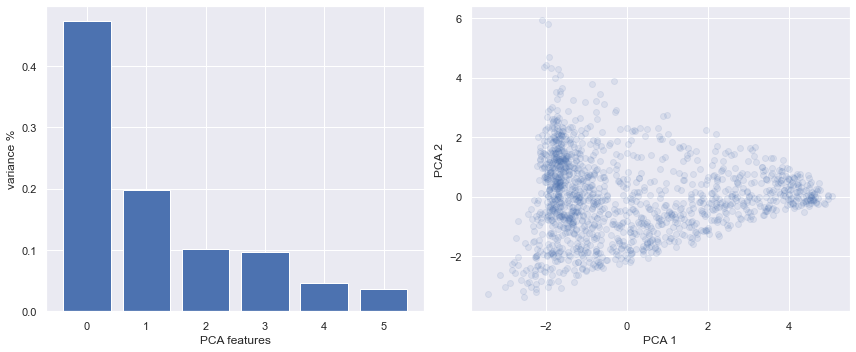

In [42]:
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=6)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [43]:
X_transformed = StandardScaler().fit_transform(pca_components)

Determine # of clusters using silhouette score method

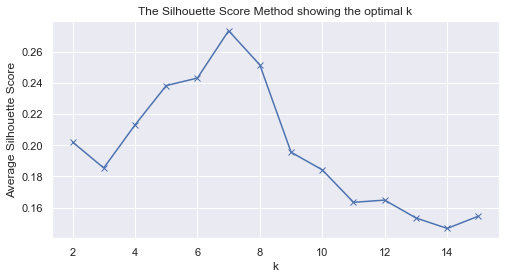

In [44]:
figsize(8, 4)
plot_silhouette_score(X_transformed)

Try 500 times to see if the clustering result stays robust. It turns out the algorithm delivers the same result 

In [63]:
# # Check stability
# check_cluster_robustness(X_transformed, 7, 500)

### Results

In [45]:
# Choose k = 7
sc = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    364
1    411
2    201
3    133
4    114
5    158
6     39
Name: Player, dtype: int64

#### OBPM & Usage by Cluster

In [46]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6
player_cluster,4,2,5,1,3,6,0
usg_pct,26.8%,22.8%,21.2%,22.1%,16.4%,17.8%,16.7%
obpm,2.48,1.22,0.57,0.15,0.10,-0.48,-0.99
Spot Up_Poss%,19.01%,20.08%,31.92%,25.69%,7.59%,34.34%,46.40%
P&R Ball Handler_Poss%,26.55%,2.68%,21.02%,44.15%,0.35%,14.74%,9.41%
Hand Off_Poss%,4.60%,1.62%,10.82%,8.45%,0.25%,25.65%,5.67%
Off Screen_Poss%,4.54%,2.72%,19.20%,4.56%,0.26%,13.86%,4.80%
Cut_Poss%,5.31%,12.88%,5.14%,3.53%,30.29%,5.89%,10.56%
Offensive Rebounds (put backs)_Poss%,3.86%,11.14%,2.53%,2.42%,23.27%,1.98%,7.05%
P&R Roll Man_Poss%,3.35%,21.05%,1.64%,0.69%,28.21%,1.42%,7.84%


- Ballhandler: 4 & 1
- Big: 2 & 3
- Wing: 5 & 6 & 0

In [50]:
cluster_dict = {4: 'Ballhandler', 1: 'Ballhandler',
                2: 'Big', 3: 'Big',
                5: 'Wing', 6: 'Wing', 0: 'Wing'}

#### Possession Weights by Cluster

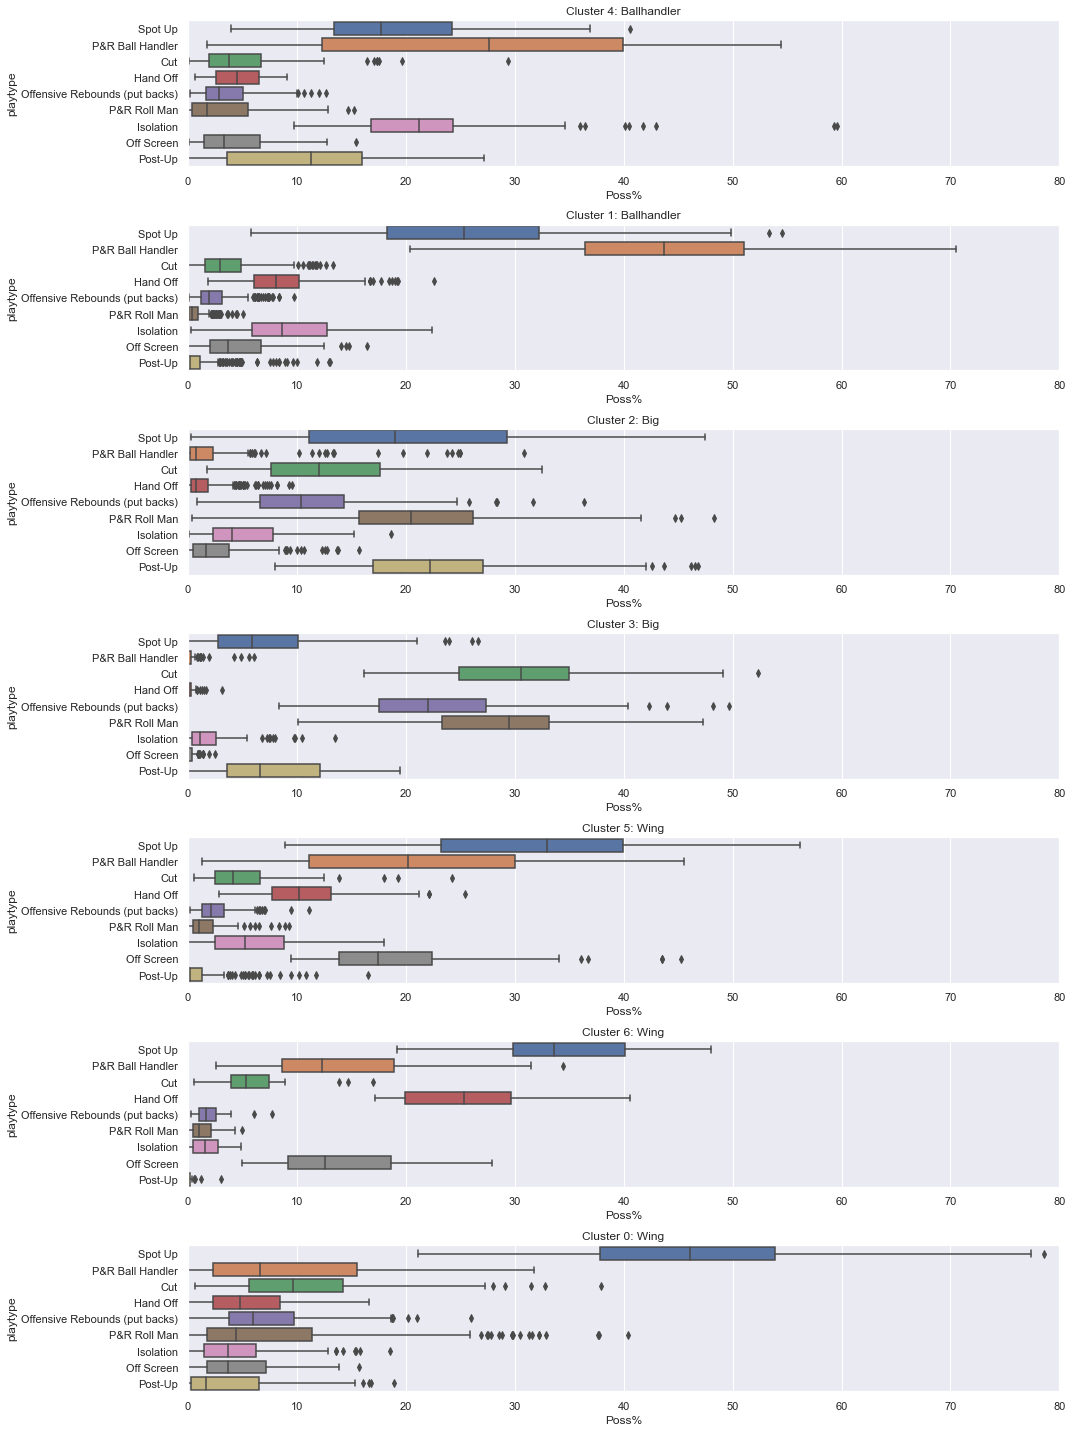

In [55]:
figsize(15, 20)
n_clusters = len(set(df['player_cluster']))
data_dict = {cluster: get_playtype_dist(df[df['player_cluster'] == cluster])
             for cluster in range(n_clusters)}

for idx, cluster in enumerate(list(cluster_dict.keys()), 1):
    data = get_playtype_dist(df[df['player_cluster'] == cluster])
    plt.subplot(n_clusters, 1, idx)
    sns.boxplot(x="Poss%", y="playtype", data=data_dict[cluster])
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}')
    plt.xlim(0, 80)

plt.tight_layout()

Summary of distribution in playtype weights:
- Good:
    - Cluster separate playtypes regarding pick & roll nicely
    - Cluster separate iso & post-up nicely
- Bad:
    - Skewed data & Outliers still exist

#### Observations

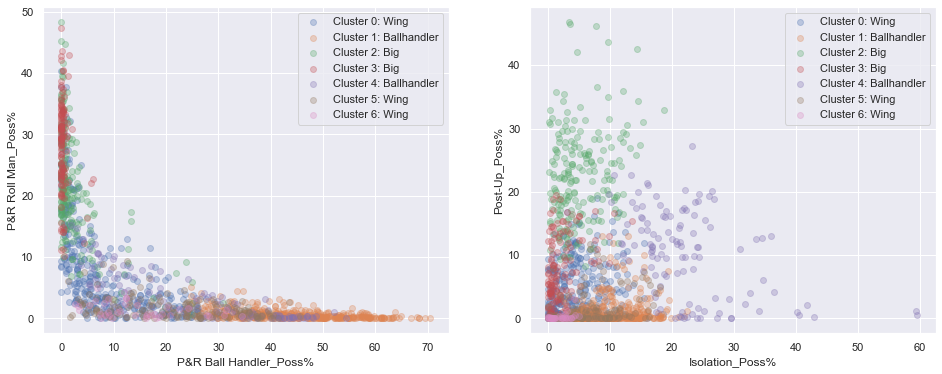

In [58]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

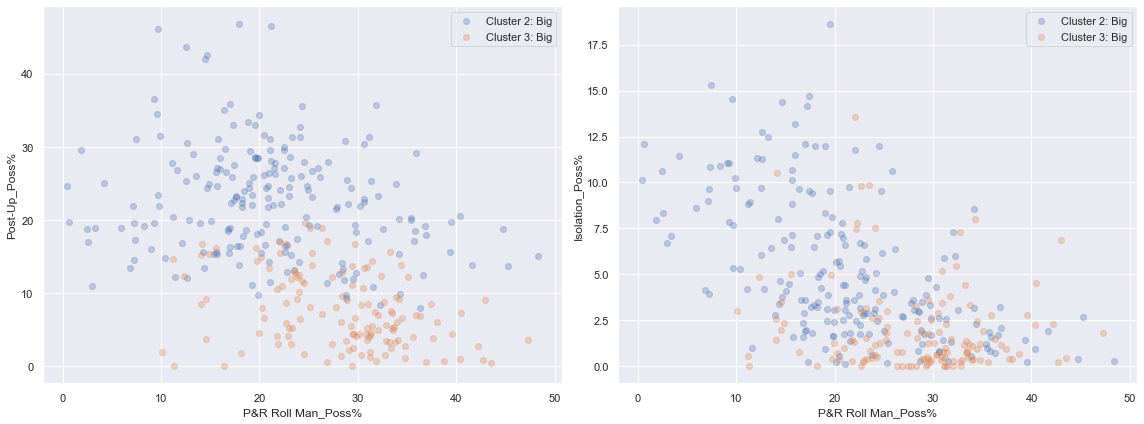

In [61]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

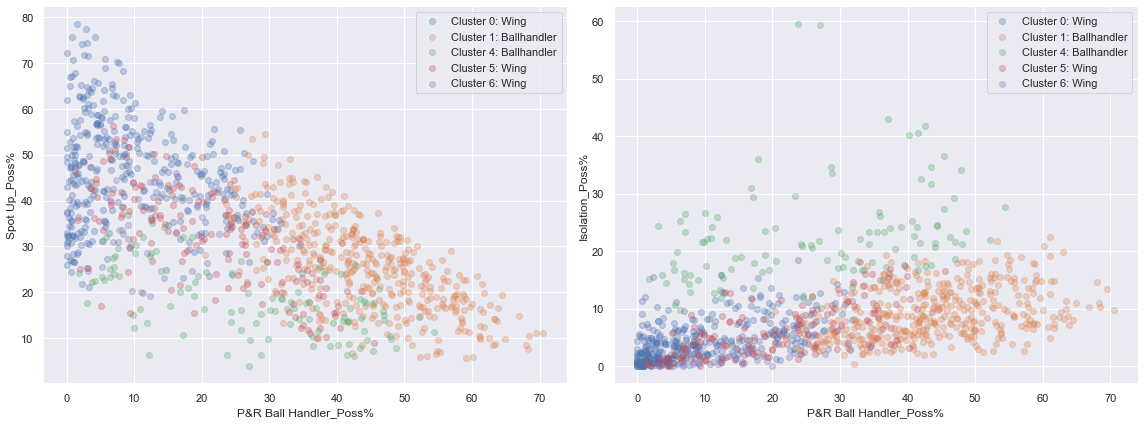

In [63]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

#### Top & Bottom Players by Cluster

##### Ballhandlers

In [64]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 114


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,James Harden,2018,Houston Rockets,9.4,Kevin Porter Jr.,2019,Cleveland Cavaliers,-3.2
1,James Harden,2017,Houston Rockets,8.5,Austin Rivers,2018,Houston Rockets,-2.9
2,James Harden,2019,Houston Rockets,8.1,Shaun Livingston,2017,Golden State Warriors,-2.8
3,Giannis Antetokounmpo,2021,Milwaukee Bucks,7.6,Dion Waiters,2017,Miami Heat,-2.1
4,Giannis Antetokounmpo,2019,Milwaukee Bucks,7.4,Austin Rivers,2019,Houston Rockets,-2.1
5,LeBron James,2017,Cleveland Cavaliers,7.3,Lance Stephenson,2017,Indiana Pacers,-1.5
6,LeBron James,2021,Los Angeles Lakers,6.9,Brandon Ingram,2018,Los Angeles Lakers,-1.3
7,Kevin Durant,2017,Golden State Warriors,6.7,Dennis Smith Jr.,2017,Dallas Mavericks,-1.2
8,LeBron James,2019,Los Angeles Lakers,6.6,Jabari Parker,2018,Chicago Bulls,-1.1
9,Kawhi Leonard,2019,Los Angeles Clippers,6.5,Wilson Chandler,2017,Denver Nuggets,-1.0


In [65]:
df[df['player_cluster'] == 4].sort_values('P&R Ball Handler_Poss%')\
[['Player', 'Season', 'P&R Ball Handler_Poss%', 'P&R Roll Man_Poss%']].head(20)

,Player,Season,P&R Ball Handler_Poss%,P&R Roll Man_Poss%
1354,Karl-Anthony Towns,2021,0.017910,0.152239
194,Michael Beasley,2017,0.030127,0.147161
529,Julius Randle,2018,0.036554,0.087903
205,Rondae Hollis-Jefferson,2017,0.042177,0.129252
759,Julius Randle,2019,0.052028,0.112875
670,Eric Paschall,2019,0.053492,0.056464
447,Paul Millsap,2018,0.055556,0.052778
114,Danilo Gallinari,2017,0.058594,0.082031
1318,Julius Randle,2021,0.063401,0.121758
1294,Aaron Gordon,2021,0.063750,0.063750


In [66]:
df[df['player_cluster'] == 4].groupby('Player')['Season']\
                             .count().reset_index().sort_values('Season', ascending=False)

,Player,Season
21,James Harden,6
37,LeBron James,5
17,Giannis Antetokounmpo,5
48,Russell Westbrook,5
34,Khris Middleton,5
10,DeMar DeRozan,4
23,Jayson Tatum,4
43,Pascal Siakam,4
29,Julius Randle,4
32,Kevin Durant,4


In [67]:
for col in df.columns:
    if 'Poss%' in col:
        print(col, df[(df['player_cluster'] == 4) & 
                      (df['Player'] == 'DeMarcus Cousins')].loc[241][col])

Spot Up_Poss% 0.2549800796812749
Transition_Poss% 0.1339075959279561
P&R Ball Handler_Poss% 0.0697211155378486
Offensive Rebounds (put backs)_Poss% 0.0796812749003984
Cut_Poss% 0.052788844621513946
Hand Off_Poss% 0.018924302788844622
Isolation_Poss% 0.16135458167330677
Off Screen_Poss% 0.044820717131474105
P&R Roll Man_Poss% 0.10657370517928287
Post-Up_Poss% 0.21115537848605578
Miscellaneous_Poss% 0.0798747063429913


In [68]:
for col in df.columns:
    if 'Poss%' in col:
        print(col, df[(df['player_cluster'] == 4) & 
                      (df['Player'] == 'Karl-Anthony Towns')].loc[1354][col])

Spot Up_Poss% 0.24253731343283583
Transition_Poss% 0.1080417434008594
P&R Ball Handler_Poss% 0.01791044776119403
Offensive Rebounds (put backs)_Poss% 0.10074626865671642
Cut_Poss% 0.06716417910447761
Hand Off_Poss% 0.027611940298507463
Isolation_Poss% 0.15149253731343285
Off Screen_Poss% 0.06194029850746269
P&R Roll Man_Poss% 0.15223880597014924
Post-Up_Poss% 0.17761194029850746
Miscellaneous_Poss% 0.0693677102516881


In [69]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 411


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Damian Lillard,2019,Portland Trail Blazers,8.3,Jalen Suggs,2021,Orlando Magic,-5.3
1,Damian Lillard,2020,Portland Trail Blazers,7.5,Frank Ntilikina,2018,New York Knicks,-5.2
2,Luka Doncic,2019,Dallas Mavericks,7.4,Aleksej Pokusevski,2020,Oklahoma City Thunder,-5.1
3,Trae Young,2021,Atlanta Hawks,7.1,Jonathon Simmons,2018,Orlando Magic,-4.6
4,Damian Lillard,2017,Portland Trail Blazers,7.0,Michael Carter-Williams,2020,Orlando Magic,-4.6
5,Kyrie Irving,2019,Brooklyn Nets,6.7,Frank Ntilikina,2017,New York Knicks,-4.5
6,Damian Lillard,2018,Portland Trail Blazers,6.6,Killian Hayes,2021,Detroit Pistons,-4.3
7,Kyrie Irving,2017,Boston Celtics,6.4,Elie Okobo,2018,Phoenix Suns,-4.2
8,Trae Young,2019,Atlanta Hawks,6.2,R.J. Hampton,2021,Orlando Magic,-4.0
9,Ja Morant,2021,Memphis Grizzlies,6.2,Ky Bowman,2019,Golden State Warriors,-4.0


##### Bigs

In [70]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 201


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Nikola Jokic,2021,Denver Nuggets,9.2,Zach Collins,2017,Portland Trail Blazers,-4.5
1,Nikola Jokic,2020,Denver Nuggets,9.1,James Wiseman,2020,Golden State Warriors,-4.0
2,Joel Embiid,2021,Philadelphia 76ers,7.2,Aron Baynes,2017,Boston Celtics,-3.6
3,Anthony Davis,2018,New Orleans Pelicans,7.1,Harry Giles,2018,Sacramento Kings,-3.4
4,Karl-Anthony Towns,2019,Minnesota Timberwolves,7.0,Robin Lopez,2019,Milwaukee Bucks,-3.0
5,Joel Embiid,2020,Philadelphia 76ers,6.3,Evan Turner,2017,Portland Trail Blazers,-2.9
6,Nikola Jokic,2018,Denver Nuggets,6.2,DeMarcus Cousins,2021,Denver Nuggets,-2.8
7,Nikola Jokic,2019,Denver Nuggets,5.5,Dirk Nowitzki,2018,Dallas Mavericks,-2.7
8,Nikola Vucevic,2020,Orlando Magic,5.5,Wendell Carter Jr.,2018,Chicago Bulls,-2.2
9,Anthony Davis,2019,Los Angeles Lakers,5.4,Skal Labissiere,2017,Sacramento Kings,-1.9


In [71]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 133


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Clint Capela,2018,Houston Rockets,3.3,Ian Mahinmi,2017,Washington Wizards,-4.6
1,Brandon Clarke,2021,Memphis Grizzlies,3.1,Precious Achiuwa,2020,Miami Heat,-3.6
2,Rudy Gobert,2018,Utah Jazz,3.0,Aron Baynes,2020,Toronto Raptors,-3.4
3,Robert Williams III,2020,Boston Celtics,2.9,Bismack Biyombo,2020,Charlotte Hornets,-3.4
4,Bam Adebayo,2020,Miami Heat,2.9,Bismack Biyombo,2017,Orlando Magic,-2.6
5,Rudy Gobert,2021,Utah Jazz,2.9,Isaiah Stewart,2021,Detroit Pistons,-2.5
6,Thomas Bryant,2019,Washington Wizards,2.9,Nerlens Noel,2020,New York Knicks,-2.4
7,Clint Capela,2020,Atlanta Hawks,2.7,Harry Giles,2019,Sacramento Kings,-2.2
8,Jarrett Allen,2021,Cleveland Cavaliers,2.7,Dewayne Dedmon,2021,Miami Heat,-2.2
9,Hassan Whiteside,2019,Portland Trail Blazers,2.5,Dwight Howard,2020,Philadelphia 76ers,-2.1


##### Wings

In [72]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 158


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Stephen Curry,2020,Golden State Warriors,8.3,Jordan Poole,2019,Golden State Warriors,-4.4
1,Stephen Curry,2017,Golden State Warriors,7.8,Justin Holiday,2018,Memphis Grizzlies,-3.3
2,Stephen Curry,2018,Golden State Warriors,7.1,Ian Clark,2018,New Orleans Pelicans,-3.3
3,Kyrie Irving,2018,Boston Celtics,6.0,Kevin Knox II,2019,New York Knicks,-3.1
4,Paul George,2018,Oklahoma City Thunder,5.6,Ben McLemore,2017,Memphis Grizzlies,-2.9
5,Stephen Curry,2021,Golden State Warriors,5.4,Ian Clark,2017,New Orleans Pelicans,-2.7
6,Bradley Beal,2019,Washington Wizards,5.3,Devin Harris,2018,Dallas Mavericks,-2.6
7,Bradley Beal,2020,Washington Wizards,4.8,Damion Lee,2021,Golden State Warriors,-2.4
8,Paul George,2020,Los Angeles Clippers,3.9,Allen Crabbe,2018,Brooklyn Nets,-2.4
9,Paul George,2019,Los Angeles Clippers,3.8,Josh Hart,2018,Los Angeles Lakers,-2.3


In [73]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 39


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,JJ Redick,2017,Philadelphia 76ers,2.2,Avery Bradley,2017,Detroit Pistons,-2.8
1,JJ Redick,2018,Philadelphia 76ers,2.2,Gary Harris,2019,Denver Nuggets,-2.8
2,Duncan Robinson,2019,Miami Heat,1.5,Wesley Matthews,2019,Milwaukee Bucks,-2.6
3,Doug McDermott,2020,Indiana Pacers,1.4,KentBazemore,2018,Atlanta Hawks,-2.5
4,Wayne Ellington,2020,Detroit Pistons,1.1,Malik Beasley,2019,Denver Nuggets,-2.2
5,Wayne Ellington,2017,Miami Heat,1.0,Rodney McGruder,2018,Miami Heat,-2.2
6,Gary Harris,2017,Denver Nuggets,1.0,Gary Harris,2021,Orlando Magic,-2.0
7,Malik Beasley,2018,Denver Nuggets,0.8,Justin Holiday,2017,Chicago Bulls,-1.6
8,Reggie Bullock,2017,Detroit Pistons,0.7,Garrison Mathews,2021,Houston Rockets,-1.3
9,Seth Curry,2020,Philadelphia 76ers,0.1,Gary Harris,2018,Denver Nuggets,-1.2


In [74]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 364


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Michael Porter Jr.,2020,Denver Nuggets,4.0,Sekou Doumbouya,2020,Detroit Pistons,-5.4
1,Christian Wood,2019,Detroit Pistons,3.5,Bruce Brown,2018,Detroit Pistons,-4.4
2,Chris Boucher,2020,Toronto Raptors,2.7,Hamidou Diallo,2019,Oklahoma City Thunder,-4.2
3,Michael Porter Jr.,2019,Denver Nuggets,2.4,Isaac Okoro,2020,Cleveland Cavaliers,-4.2
4,Mikal Bridges,2020,Phoenix Suns,2.4,Wayne Selden,2018,Chicago Bulls,-4.0
5,Brandon Clarke,2019,Memphis Grizzlies,2.4,Grant Williams,2020,Boston Celtics,-4.0
6,Tobias Harris,2017,Detroit Pistons,2.2,Stanley Johnson,2017,Detroit Pistons,-4.0
7,Christian Wood,2021,Houston Rockets,2.1,Terrance Ferguson,2018,Oklahoma City Thunder,-3.9
8,Malcolm Brogdon,2018,Milwaukee Bucks,2.0,Joshua Primo,2021,San Antonio Spurs,-3.9
9,Cameron Johnson,2021,Phoenix Suns,2.0,Wesley Iwundu,2018,Orlando Magic,-3.8


#### Edge Cases

In [75]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
0,Aaron Gordon,"{0, 2, 4}","{Big, Ballhandler, Wing}",3
47,Bruce Brown,"{0, 1, 3}","{Big, Ballhandler, Wing}",3
184,Harrison Barnes,"{0, 2, 4}","{Big, Ballhandler, Wing}",3
407,Paul Millsap,"{0, 2, 4}","{Big, Ballhandler, Wing}",3
427,Rondae Hollis-Jefferson,"{0, 3, 4}","{Big, Ballhandler, Wing}",3
472,Tobias Harris,"{0, 2, 4}","{Big, Ballhandler, Wing}",3


In [76]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
34,Ben Simmons,"{1, 2, 4}","{Big, Ballhandler}",2
60,Carmelo Anthony,"{2, 4}","{Big, Ballhandler}",2
88,Danilo Gallinari,"{2, 4}","{Big, Ballhandler}",2
107,DeMarcus Cousins,"{2, 4}","{Big, Ballhandler}",2
270,Julius Randle,"{2, 4}","{Big, Ballhandler}",2
275,Karl-Anthony Towns,"{2, 4}","{Big, Ballhandler}",2
336,Marcus Morris,"{2, 4}","{Big, Ballhandler}",2
337,Marcus Morris Sr.,"{2, 4}","{Big, Ballhandler}",2
515,Zion Williamson,"{2, 4}","{Big, Ballhandler}",2


### Visualization via TSNE

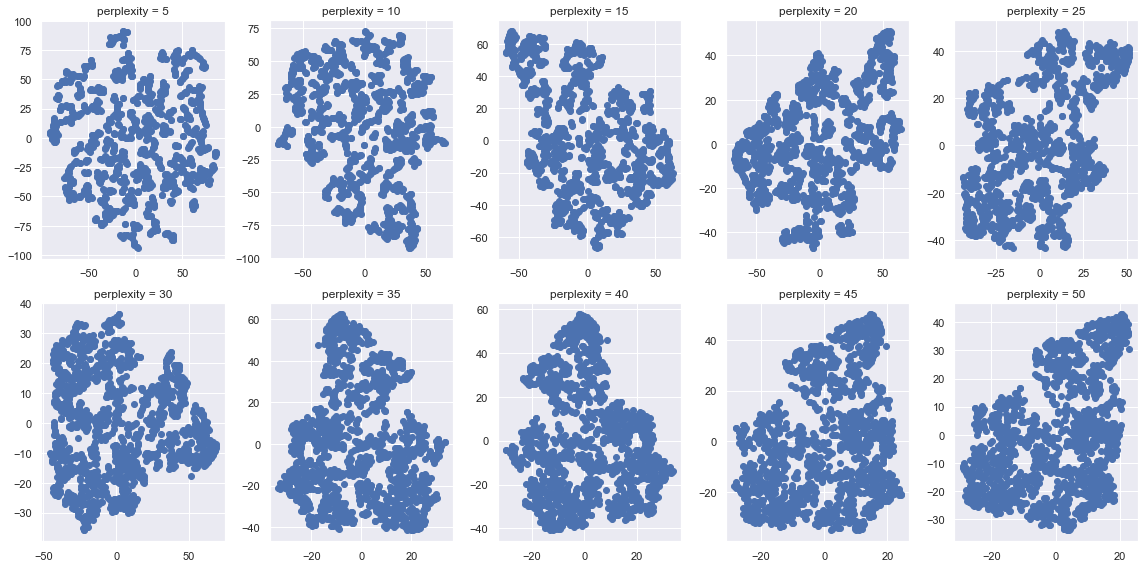

In [77]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [78]:
tsne = TSNE(perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

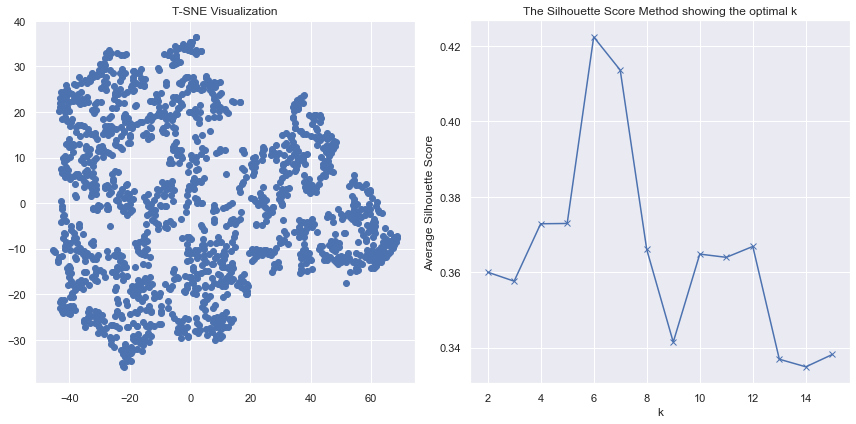

In [79]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [80]:
df_tsne = df.copy()
# Choose k = 6
sc_tsne = SpectralClustering(n_clusters=6, affinity='nearest_neighbors', random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

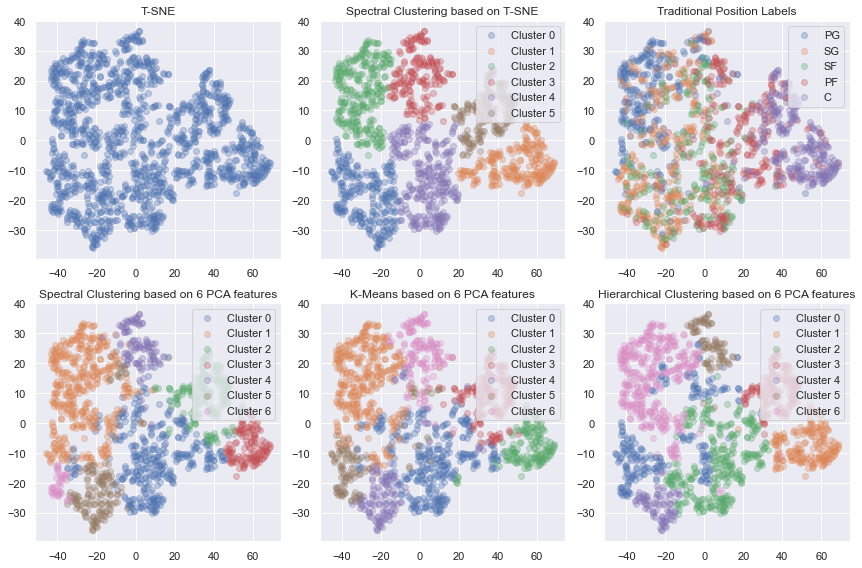

In [81]:
figsize(12, 8)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')

plt.subplot(2, 3, 2)
for i in range(6):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend()
plt.title('Traditional Position Labels')

n_clusters = 7

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('Spectral Clustering based on 6 PCA features')


plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('K-Means based on 6 PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend()
plt.title('Hierarchical Clustering based on 6 PCA features')

plt.tight_layout()

(-40.0, 60.0)

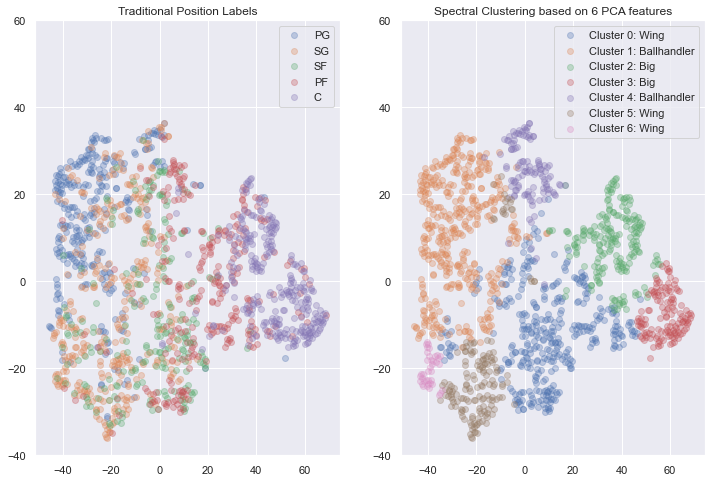

In [131]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend()
plt.title('Traditional Position Labels')
plt.ylim(-40, 60)

n_clusters = 7

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
plt.title('Spectral Clustering based on 6 PCA features')
plt.ylim(-40, 60)

In [118]:
lookup_idx = df[df['player_cluster'] == 4].sort_values('P&R Ball Handler_Poss%')\
             [['Player', 'Season', 'P&R Ball Handler_Poss%', 'P&R Roll Man_Poss%']]\
                                          .head(20).index

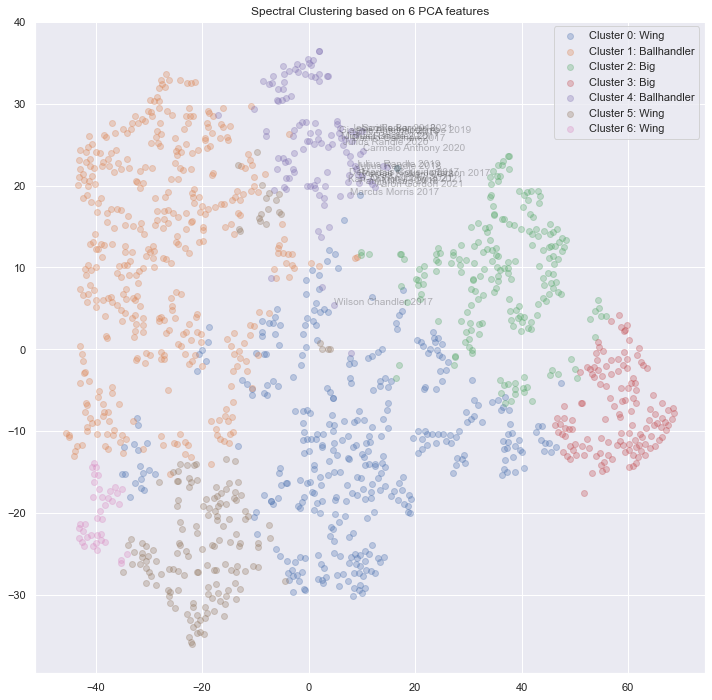

In [121]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']}", 
                 player_coord, alpha=0.3)
    

In [139]:
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
0,Aaron Gordon,"{0, 2, 4}","{Big, Ballhandler, Wing}",3
47,Bruce Brown,"{0, 1, 3}","{Big, Ballhandler, Wing}",3
184,Harrison Barnes,"{0, 2, 4}","{Big, Ballhandler, Wing}",3
407,Paul Millsap,"{0, 2, 4}","{Big, Ballhandler, Wing}",3
427,Rondae Hollis-Jefferson,"{0, 3, 4}","{Big, Ballhandler, Wing}",3
472,Tobias Harris,"{0, 2, 4}","{Big, Ballhandler, Wing}",3


In [165]:
three_cluster_players = list(temp[temp['n_cluster'] == 3]['Player'])
lookup_idx = df[df['Player'].isin(['Tobias Harris', 'Aaron Gordon'])].index

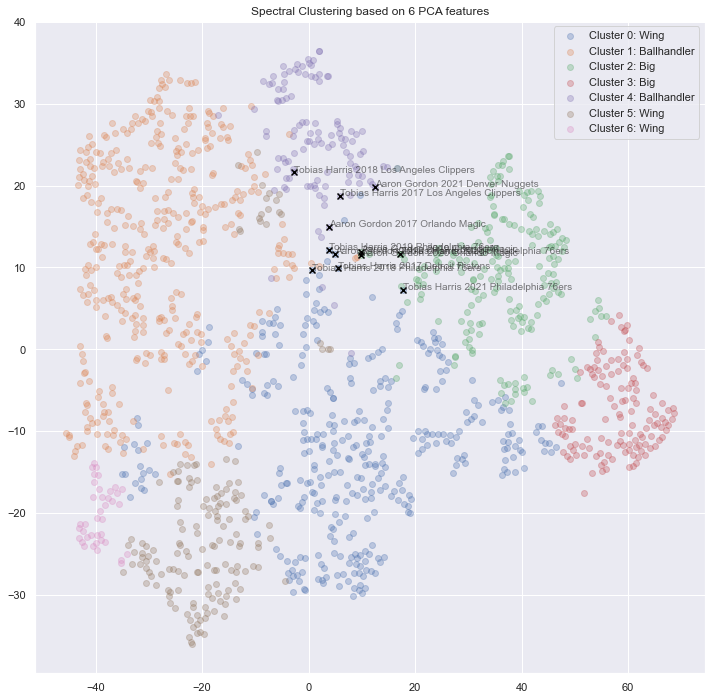

In [166]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    

In [175]:
three_cluster_players = list(temp[temp['n_cluster'] == 3]['Player'])
lookup_idx = df[df['Player'].isin(['Bruce Brown', 
                                   'Ben Simmons',
                                   'Rondae Hollis-Jefferson'])].index

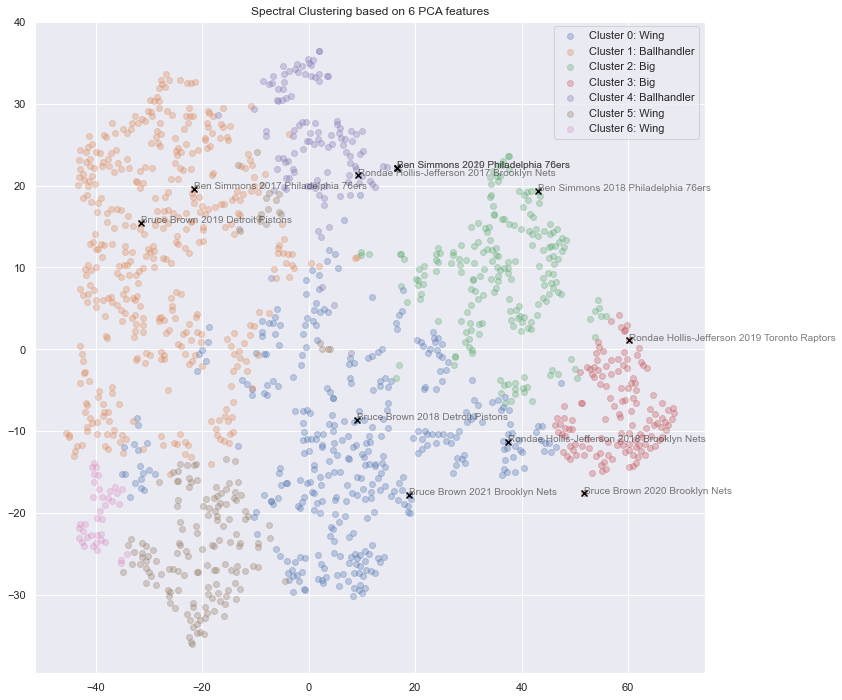

In [176]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    

In [185]:
lookup_idx = df[df['Player'].isin(['Karl-Anthony Towns', 
                                   'DeMarcus Cousins',
                                   'Zion Williamson'])].index

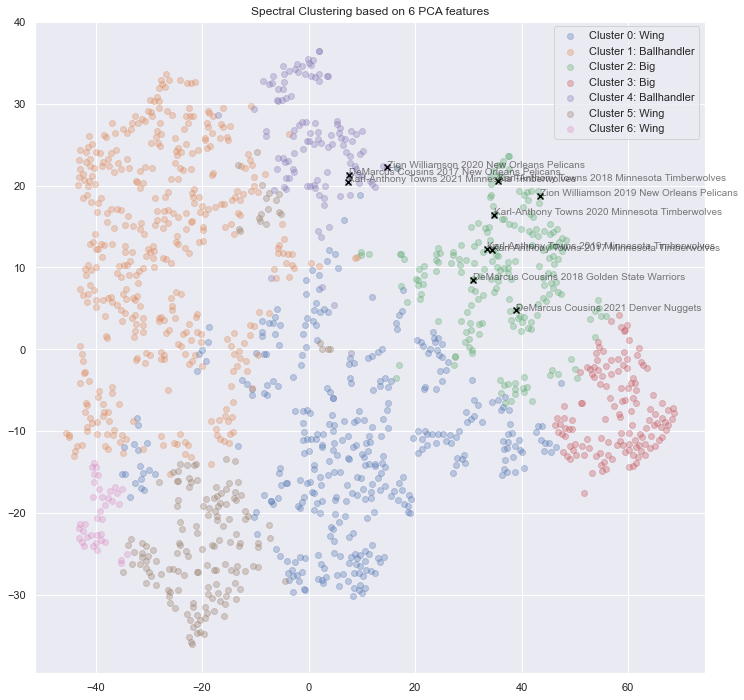

In [186]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    

In [183]:
lookup_idx = df[df['Player'].isin(['Eric Paschall', 
                                   'Harrison Barnes',
                                   'Danilo Gallinari'])].index

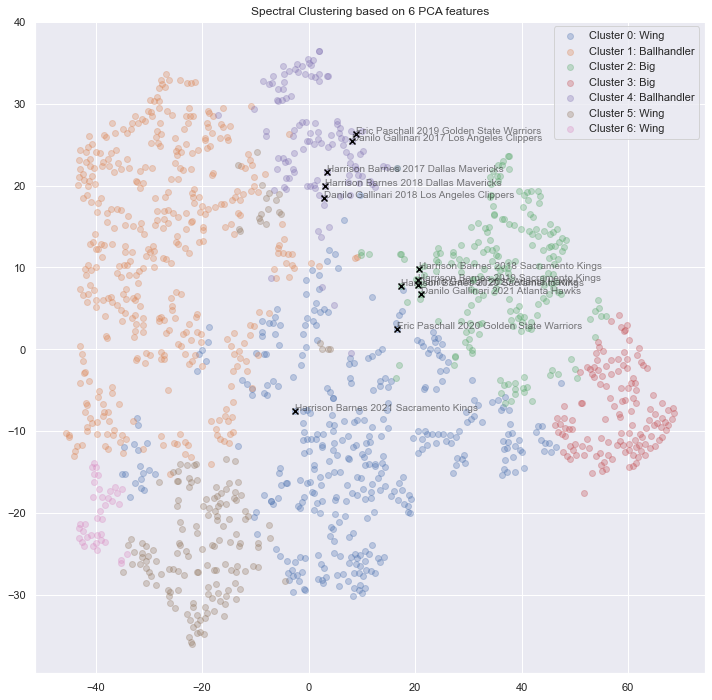

In [184]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    

In [215]:
lookup_idx = df[df['Player'].isin(['Jayson Tatum', 
                                   'Jaylen Brown',
                                   'Marcus Smart',
                                   'Al Horford',
                                   'Robert Williams III'])].index

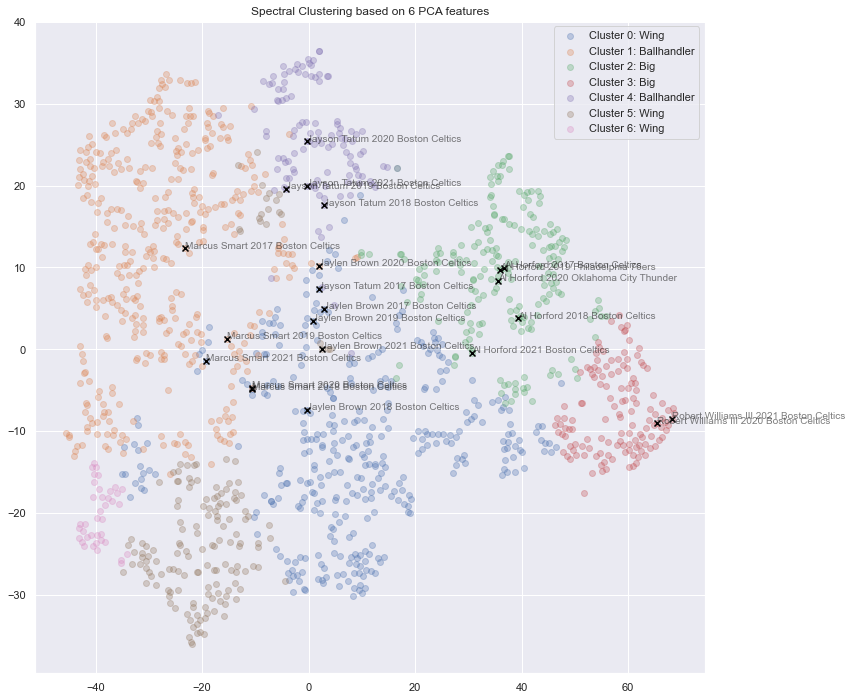

In [216]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    

In [217]:
lookup_idx = df[df['Player'].isin(['Stephen Curry', 
                                   'Klay Thompson',
                                   'Draymond Green',
                                   'Andrew Wiggins',
                                   'AndrewWiggins',
                                   'Jordan Poole'])].index

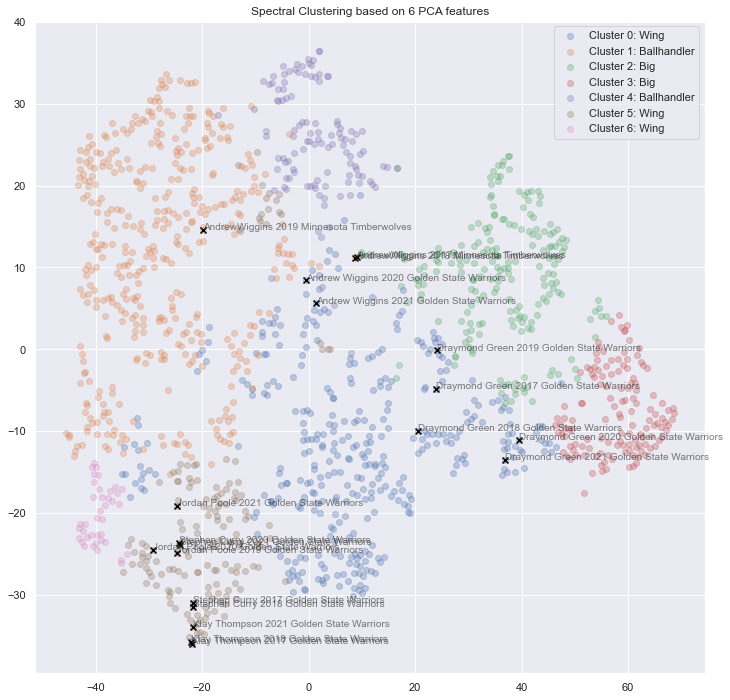

In [218]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    

In [221]:
lookup_idx = df[df['Player'].isin(['Kyrie Irving', 
                                   'Giannis Antetokoumpo',
                                   'Kevin Durant',
                                   'Jimmy Butler',
                                   'Bam Adebayo'])].index

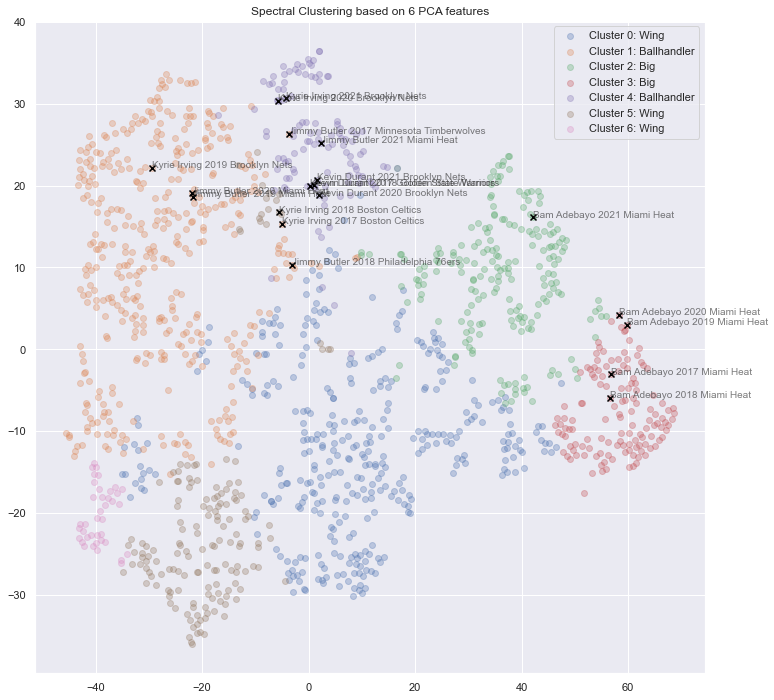

In [222]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    

In [223]:
lookup_idx = df[df['Player'].isin(['Kyrie Irving', 
                                   'James Harden'])].index

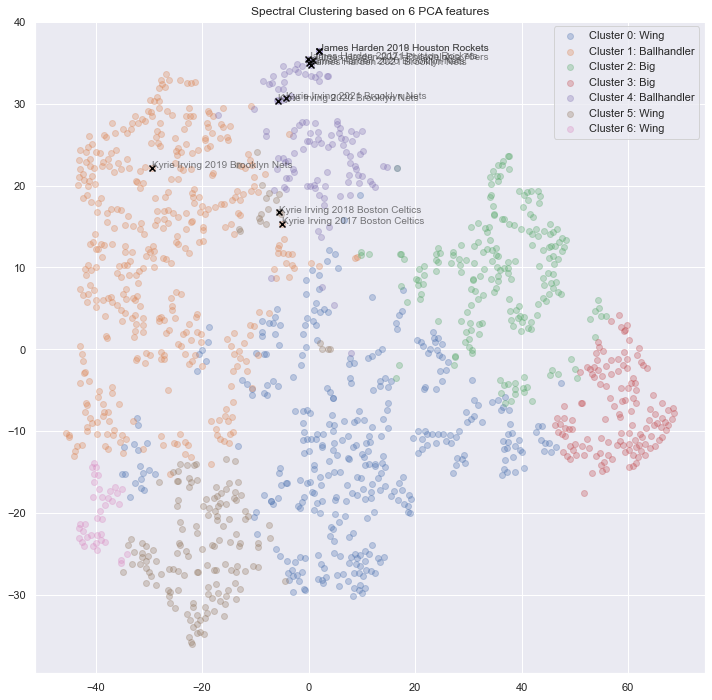

In [224]:
figsize(12, 12)

n_clusters = 7
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend()
# plt.xlim(-20, 40)
# plt.ylim(0, 40)
plt.title('Spectral Clustering based on 6 PCA features')
for idx in lookup_idx:
    player_coord = X_tsne[idx]
    plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
    plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                 player_coord, alpha=0.6)
    